In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as manimation
import pickle
import pandas as pd
import pyret
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve1d
from numpy import unravel_index
import scipy
from scipy.interpolate import interp1d


# read STAs

In [2]:
#read sta info
filename = "/user/sebert/home/Documents/Experiments/OSR/Results/20210326_Thomas/resultfiles/sta_data.pkl"
with open(filename, "rb") as handle:   #Pickling
    stadict = pickle.load(handle)
    
stadict.keys()

STAs = stadict['STAs']
rasters_check_rep = stadict['rasters_check_repeated']
rasters_check = stadict['rasters_check']
temporal = stadict['temporal']
spatial = stadict['spatial']


nb_staframes = 40
frame_rate = 1/40
filtertime = np.arange(-nb_staframes,0)*frame_rate


# load checkerpoard stimulus

In [3]:

#load checkerboard stimulus
nb_checks = 24
nb_frames = 120000

stimulus_path = "/user/sebert/home/Documents/Experiments/OSR/DataAnalysis/STA/checkerboard_{}checks_{}frames.npy".format(nb_checks,nb_frames)

#checkerboard_24checks_120000frames = np.ones((nb_frames,nb_checks,nb_checks), dtype='uint8')
checkerboard_24checks_120000frames = np.load(stimulus_path)

#stimulus for one repeated sequence
checker_repeats = checkerboard_24checks_120000frames[:600,:,:]
checker_repeats = checker_repeats.astype(np.float64)

stimulus = checker_repeats
stimulus -= stimulus.mean()
stimulus /= stimulus.std()



checker = checkerboard_24checks_120000frames.astype(np.float64)
stimulusnonrepeated = checker
stimulusnonrepeated -= stimulusnonrepeated.mean()
stimulusnonrepeated /= stimulusnonrepeated.std()


# load checkerboard responses

In [6]:



# load response
 
filename = "/user/sebert/home/Documents/Experiments/OSR/Results/20210326_Thomas/resultfiles/sta_data.pkl"
with open(filename, "rb") as handle:   #Pickling
    stadict = pickle.load(handle)
    
stadict.keys()


rasters_check_rep = stadict['rasters_check_repeated']
rasters_check = stadict['rasters_check']

repeated_checker_response = np.asarray(rasters_check_rep[c])

nb_repeats = len(repeated_checker_response)


# counts for repeated 
counts = []
for rep in range(nb_repeats):
    countt,bins = np.histogram(repeated_checker_response[rep], bins = 600, range = (0,15))
    counts.append(countt)


# counts concatenated
count,bins = np.histogram(np.concatenate(repeated_checker_response), bins = 600, range = (0,15))
count = count/nb_repeats

/user/sebert/home/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


# choos a cell and get STA

In [5]:
c = 5
sta = STAs[c]

sta -= sta.mean()
sta /= sta.std()

time_rf = temporal[c]
space_rf = spatial[c]


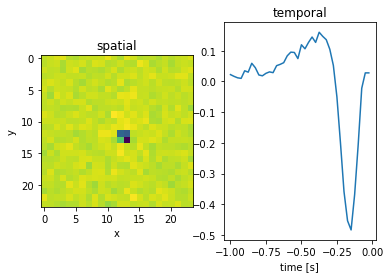

In [7]:
# visualize STA in 2D animation
#%matplotlib notebook
fig = plt.figure()
spatial_dimension = (sta.shape[1],sta.shape[2])
data = np.zeros(spatial_dimension)

ax3 = fig.add_subplot(122)
ax3.plot(filtertime,time_rf)
ax3.set_xlabel('time [s]')
ax3.set_ylabel('Stimulus Intensity')
ax3.set_title('temporal')


ax2 = fig.add_subplot(121)
ax2.imshow(space_rf)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('spatial')


plt.show()





# Linear Predictions with STA from data

convoution of stimulus and filter. Numerically compute dot product.


In [8]:
def design_matrix_2D(stimulus,td=40):
    
    stimulus_timesteps = stimulus.shape[0]+td
    preceeding_stimulus_length = stimulus.shape[1]*stimulus.shape[2]*td
    
    stimulus_padded = np.concatenate((np.zeros((td,stimulus.shape[1],stimulus.shape[2])),stimulus))
    X = np.zeros((stimulus_timesteps,preceeding_stimulus_length))
    
    for t in range(stimulus_timesteps):
        if t < td:
            continue
        else:
            X[t,:] = stimulus_padded[t-td:t,:,:].ravel()
        
    return X[td:,:]


    
def predict_2D(stimulus,sta):

    X = design_matrix_2D(stimulus)

    return np.dot(X, sta.flatten())
    return X @sta.flatten()

        

    
    
def predict(stimulus,sta):


    return np.convolve(stimulus,sta, mode = 'full')[:-len(sta)+1]

        

def visualize_stimulus_response(stim,response,stimt,dt):


    fig = plt.figure()

    axstim = fig.add_subplot(121)
    axstim.imshow(stim[0,:,:],vmax = 1, vmin = 0)
    axstim.set_title('Stimulus')
    axstim.set_xlabel('x')
    axstim.set_ylabel('y')


    time = np.arange(0,stimt,dt)
    axres = fig.add_subplot(122)
    axres.plot(time,response/response.max(), label = 'response prediction')
    axres.plot(time,np.flip(time_rf)/time_rf.max(), label = 'temporal filter profile', color = 'blue', alpha = .2, linewidth = 6)

    axres.set_xlabel('time [s]')
    axres.set_title('Response')
    
    fig.legend()

    plt.show()

In [9]:
response_check = predict_2D(stimulus,-sta)

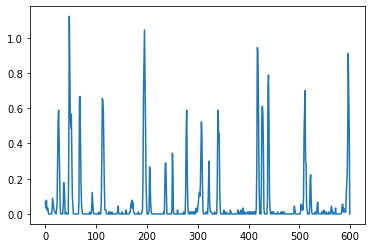

In [10]:
plt.plot(count)

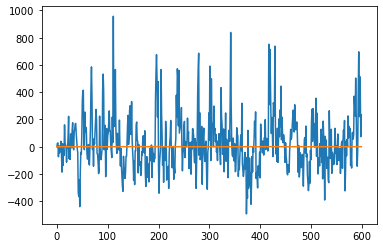

In [11]:
plt.plot(response_check)
plt.plot(count)

/user/sebert/home/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


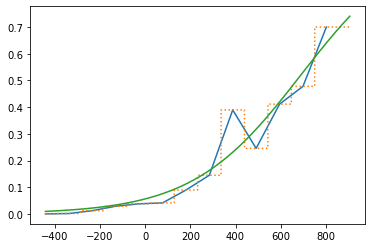

In [14]:
# get nonlinearity

spikes_binned = count
num_fbins = 14
rep = 0 
mean_fx = np.zeros(num_fbins)
mean_fy = np.zeros(num_fbins)
# bin filter output and get bin index for each filtered stimulus
countpred,bin_edges = np.histogram(response_check,num_fbins)
bin_idx = np.digitize(response_check, bins=bin_edges) - 1
fx = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2 # use bin centers for x positions

# now compute mean spike count in each bin
fy = np.zeros(num_fbins) # y values for nonlinearity
for jj in np.arange(num_fbins):
    fy[jj] = np.mean(spikes_binned[bin_idx==jj])
#fy = fy/(bin_edges[1]-bin_edges[0]) # divide by bin size to get units of sp/s;
fnlin = interp1d(fx[:-1],fy[:-1],kind='nearest', bounds_error=False, fill_value='extrapolate')
fxrange = np.arange(np.min(fx),np.max(fx),0.01)
fyrange = fnlin(fxrange)
plt.plot(fx,fy)
plt.plot(fxrange,fyrange, linestyle = ':')

popt, pcov = scipy.optimize.curve_fit(sig, fxrange,fyrange)

#plt.plot(fx,sig(fx,1,0,60))
plt.plot(fxrange,sig(fxrange,*popt))


In [15]:
fxrange,fyrange, popt

(array([-441.19625257, -441.18625257, -441.17625257, ...,  905.55374743,
         905.56374743,  905.57374743]),
 array([0. , 0. , 0. , ..., 0.7, 0.7, 0.7]),
 array([4.15319623e-03, 6.90481104e+02, 1.04350619e+00]))

In [13]:
# fit sigmoid 

def sig(x, slope,threshold,max_val):

    return max_val/ (1 + np.exp(-slope * (x - threshold)))

popt, pcov = scipy.optimize.curve_fit(sig, fx[:-1],fy[:-1])


/tmp/ipykernel_409636/1776062909.py:5: RuntimeWarning: overflow encountered in multiply
  return max_val/ (1 + np.exp(-slope * (x - threshold)))
/user/sebert/home/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [67]:
# # get nonlinearity
# spikes_binned = counts
# num_fbins = 100
# rep = 0 
# mean_fy = np.zeros(num_fbins)
# # bin filter output and get bin index for each filtered stimulus
# countpred,bin_edges = np.histogram(response_check,num_fbins)
# bin_idx = np.digitize(response_check, bins=bin_edges) - 1
# fx = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2 # use bin centers for x positions

# # now compute mean spike count in each bin
# for rep in range(nb_repeats):
#     fy = np.zeros(num_fbins) # y values for nonlinearity
#     for jj in np.arange(num_fbins):
#         fy[jj] = np.mean(spikes_binned[rep][bin_idx==jj])
#     fy = fy/dt # divide by bin size to get units of sp/s;
#     mean_fy = mean_fy + fy
    
#     plt.plot(fx,fy)

# mean_fy = mean_fy/nb_repeats


# Predict Euler Response

In [16]:
# load euler response
filename = "/user/sebert/home/Documents/Experiments/OSR/Results/20210326_Thomas/resultfiles/20210326_euler_grade_isi.pkl"
with open(filename, "rb") as handle:   #Pickling
    infodict = pickle.load(handle)
    
def get_euler_response(cell):
    return infodict[f'temp_{cell}']['control']['euler_count']


euler_data = get_euler_response(c)
    
# load euler stimulus
stimeuler = pd.read_csv('/user/sebert/home/Documents/Experiments/OSR/StimulusDesgin/Euler_Baptiste/euler_luminance_profile.csv')
euler = np.asarray(stimeuler['luminance'])

euler = (euler - euler.mean())/euler.std()


In [17]:
# predict euler respone
euler_2D = np.zeros((len(euler),24,24))
for i in range(len(euler)):
    euler_2D[i,:,:] = euler[i]
    
pred_euler_linear = predict_2D(euler_2D,sta)
pred_euler = sig(pred_euler_linear,*popt)

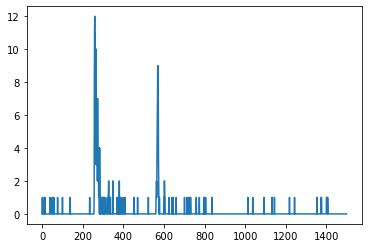

In [18]:
# show
plt.plot(euler_data)


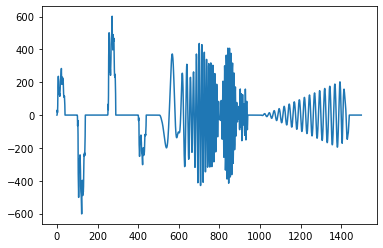

In [19]:
plt.plot(pred_euler_linear)


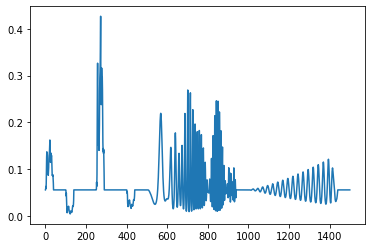

In [20]:
plt.plot(pred_euler)